# Première prise de charge et calcul de rendement pondéré

Chargement de module utile pour la suite

In [1]:
import pandas as pd                      # pour gerer les tableaux de données comme excel
import numpy as np                       # pour les calculs sur des données matricielles
import matplotlib.pyplot as plt          # pour les traces
import matplotlib.ticker as tck          # pour le formateage de labels
from scipy.interpolate import interp1d   # pour l'interpolation du rendement pondere

In [2]:
# chargement du module specifique
import os
import sys
sys.path.insert(0, os.path.abspath('../common'))
# pour la lecture et l'interpolation de la colline donnée
from module_turbine_data import CollineModeleClass

## Constantes physiques

* accélération gravitationnelle `g` en m$^2$/s$^2$
* température de l'eau `T_w` en K
* masse volumique de l'eau `rho` considérée comme constante dans toute la suite, calculée à l'aide du tableau B.2 de la norme CEI 60193 pour la temperature de 10°C
* viscosité cinématique de l'eau à 10°C

In [3]:
g = 9.8105
T_w = 10+273.15
rho = 1000.1
nu = 1.308e-6

## Données du problème

* Puissance électrique `P_e` en Watt
* Rendement de l'alternateur `eta_alt`
* Rendement hydraulique `eta_h`
* Facteur de puissance `P_ED`
* Chutte nominale `H` en mètre

In [4]:
P_e = 150e6
eta_alt = 98.4/100.
P_ED = 0.9
H = 60.0

* Puissance mécanique $P_m = \rho g H Q \eta_h$, elle correspond à la puissance à l'arbre `P_m`
$$\eta_{alt} = \frac{P_e}{P_m}$$

In [5]:
P_m = P_e / eta_alt
print('P_m = {0:.2f} MW'.format(P_m/1e6))

P_m = 152.44 MW


## Donnees du devoir

In [6]:
# chemin vers le fichier excel contenant les donnees turbinier
input_excel_colline = os.path.abspath('../common/data_project.xlsx')
Re_M = 7.0e6
# on cree une instance de la classe CollineModele qui sera utilisee pour l'interpolation
colline_modele = CollineModeleClass(input_excel_colline,Re_M,convert_to_m3s=True)

## Pondération du rendement
La pondération du rendement nous permet de choisir le point de rendement maximum (sommet de la colline) au point qui a le plus de poids dans l'évaluation par le client. Le tableau donné ne fournit pas le % de $P_m$ à attribuer au sommet, je choisis de le mettre à 85% de $P_m$.

In [7]:
ponderation = pd.DataFrame({'% P_m': [100,90,80,70,60],'Poids': [10,20,40,20,10]})
ponderation['Puissance [W]'] = ponderation['% P_m']/100 * P_m

In [8]:
ponderation

,% P_m,Poids,Puissance [W]
0,100,10,1.524390e+08
1,90,20,1.371951e+08
2,80,40,1.219512e+08
3,70,20,1.067073e+08
4,60,10,9.146341e+07


Lecture de la colline de rendement, création des fonction d'interpolation $Q_{11}=f_{Q}\left(\gamma,n_{11}\right)$ et $\eta_{h,M} = f_{\eta}\left(\gamma,n_{11}\right)$. L'indice $M$ correspond au rendement du modèle à $Re_M=7 \times 10^6$

Système $Q_{11}$, $N_{11}$ respectivement en $m^3/s$ et en rpm
\begin{align}
Q_{11} & = \frac{Q}{D^2 \sqrt{H}}\\
N_{11} & = \frac{n_{rpm} D}{\sqrt{H}}
\end{align}

In [9]:
colline_modele.interpol_colline(spline_order=2)

### Facteur d'échelle protype / modèle
Les effets de Reynolds (du fait de la similitude partielle modèle/prototype) modifie le rendement mesuré sur le modèle (données fournies) et le rendement qui serait obtenu sur le prototype. Pour débuter on supposera une différence de rendement de $\Delta \eta_{p,M} = 1.5 \%$. Cette valeur sera réévaluée par la suite.

In [10]:
d_eta_maj_pm = 0.015

### Initialisation

On choisit un point proche du maximum de rendement

In [11]:
n11 = 85.0
q11 = 0.800
gamma = colline_modele.lsq_get_gamma_from_Q11_N11(q11,n11)
eta_hM = colline_modele.f_eta(gamma,n11)[0]
print('eta_hM = {0:.2f} %'.format(eta_hM*100))

eta_hM = 91.21 %


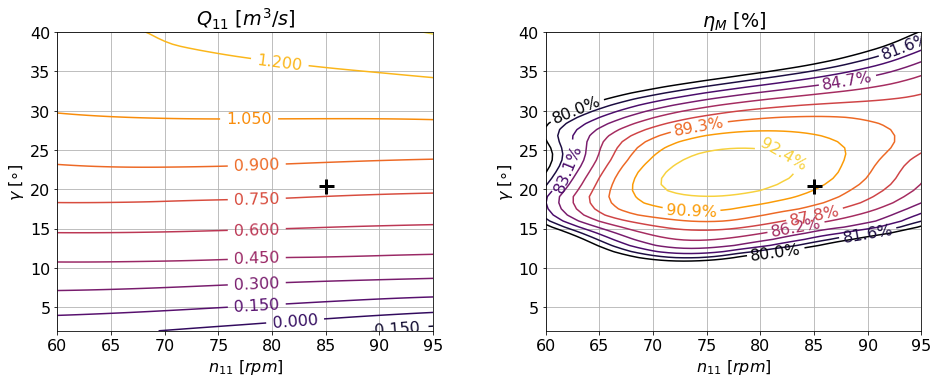

In [12]:
fig,ax = colline_modele.plot_colline(nlevels=10);
ax[0].plot(n11,gamma,'+',ms=15,color='black',markeredgewidth=3.0);
ax[1].plot(n11,gamma,'+',ms=15,color='black',markeredgewidth=3.0);

In [13]:
P_design = 0.75 * P_m
Q = P_design /(rho * g * H * (eta_hM+d_eta_maj_pm))
D = np.sqrt( (Q/q11) / np.sqrt(H))
n_rpm = n11*np.sqrt(H)/D
print('P_design={0:.2f} MW'.format(P_design/1.0e6))
print('eta_M={0:.1f} %'.format(eta_hM*100))
print('d_eta_maj_pm={0:.1f}%'.format(d_eta_maj_pm*100))
print('Q={0:.2f} m3/s'.format(Q))
print('D={0:.2f} m'.format(D))
print('n_rpm={0:.2f} rpm'.format(n_rpm))

P_design=114.33 MW
eta_M=91.2 %
d_eta_maj_pm=1.5%
Q=209.47 m3/s
D=5.81 m
n_rpm=113.24 rpm


###  Calcul de la vitesse synchrone
La fréquence de rotation doit être un multiple de 60 Hz.  
Corrige la valeur de $n_{11}$ et récupère l'ouverture de directrive.  
Calcule le rendement au point synchrone

In [14]:
n_rpm_sync = colline_modele.sync_rot(n_rpm,Q,D,H)
q11,n11,gamma = colline_modele.get_Q11_n11_gamma(D,Q,n_rpm_sync,H)
print('(Q11,N11)=({0:.3f},{1:.2f})'.format(q11,n11))
print('Ouverture directrice [deg]',gamma)
eta_hM_sync = colline_modele.f_eta(gamma,n11)
print('eta_hM [%]',eta_hM_sync*100)

Nombre de poles: 32
(Q11,N11)=(0.800,84.44)
Ouverture directrice [deg] [20.4106534]
eta_hM [%] [91.41968989]


# Prise de charge
On procède à une prise de charge à la chute constante, au diamètre précédemment déterminé et à la vitesse synchrone déterminée, donc à $N_{11}$ fixée.

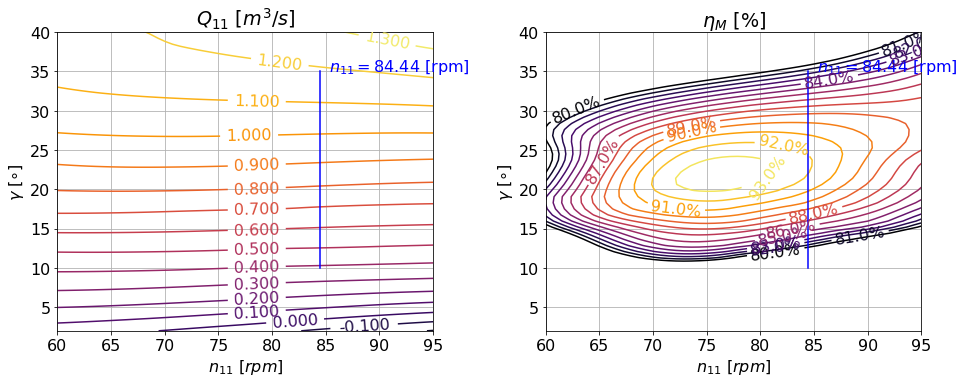

In [15]:
WG_deg_vec = np.linspace(10,35)
Q11_vec = colline_modele.f_Q11(WG_deg_vec,n11)
eta_M_vec = colline_modele.f_eta(WG_deg_vec,n11)
fig,ax = colline_modele.plot_colline();
ax[0].plot(n11*np.ones_like(WG_deg_vec),WG_deg_vec,color='blue');
label = [r'$n_{11} = $','{0:.2f}'.format(n11),' [rpm]']
ax[0].text(1.01*n11, 35,''.join(label),color='blue')
ax[1].plot(n11*np.ones_like(WG_deg_vec),WG_deg_vec,color='blue');
ax[1].text(1.01*n11, 35,''.join(label),color='blue');

### Calcul de la majoration d'efficacité prototype modèle
Calcul du point de rendement max sur la prise de charge

In [16]:
iopt = np.argmax(eta_M_vec)
Q11_opt = Q11_vec[iopt]
eta_M_opt = eta_M_vec[iopt]

In [17]:
Re_p = (2*np.pi * n_rpm_sync / 60.) * D/2 * D / nu

Pertes relatives transposables à $Re_M$ avec $V_{ref}=0.7$ pour une turbine Francis

In [18]:
delta_M = (1.0 - eta_M_opt) * 0.7
print('delta_M={0:0.3f} %'.format(delta_M*100.))
d_eta_maj_pm = delta_M * (1 - (Re_M/Re_p)**0.16)
print('d_eta_maj_pm={0:0.3f} %'.format(d_eta_maj_pm*100.))

delta_M=5.507 %
d_eta_maj_pm=2.143 %


Rendement pondere: 92.83 %


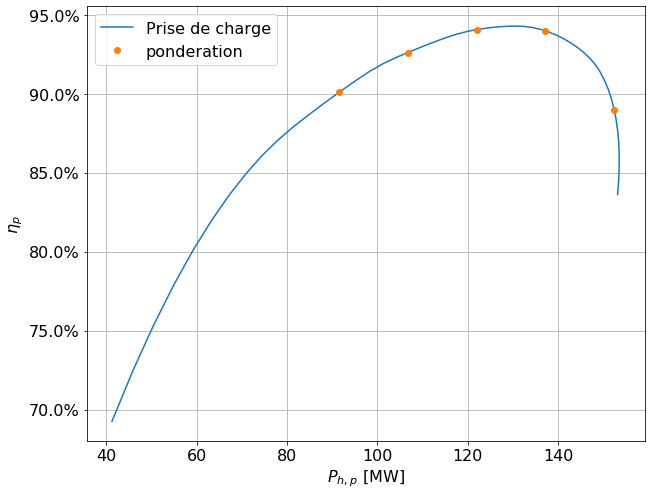

In [23]:
Q_vec = Q11_vec * D**2 * np.sqrt(H)
P_vec = rho * g * H * Q_vec * (eta_M_vec+d_eta_maj_pm)
plt.plot(P_vec/1.0e6,eta_M_vec+d_eta_maj_pm,label='Prise de charge')
if np.all((ponderation['Puissance [W]']>P_vec.min()) & (ponderation['Puissance [W]']<P_vec.max())):
    f_P_eta = interp1d(P_vec,eta_M_vec+d_eta_maj_pm,fill_value='extrapolate')
    eta_node = f_P_eta(ponderation['Puissance [W]'])
    Q_node = ponderation['Puissance [W]']/(rho* g * H * eta_node)
    Q11_node = Q_node  / ( D**2 * np.sqrt(H) )
    ponderation['eta_p'] = eta_node
    eta_weighted = np.sum( eta_node * ponderation['Poids'])/100.
    print('Rendement pondere: {0:.2f} %'.format(eta_weighted*100))
    plt.plot(ponderation['Puissance [W]']/1.0e6,eta_node,'o',label='ponderation')
else:
    print('Puissances non accessible')
    print('Bornes prise de charge [MW]: ({0:.1f},{1:.1f})'.format(P_vec.min()/1.0e6,P_vec.max()/1.0e6))
plt.ylabel(r'$\eta_p$')
plt.xlabel(r'$P_{h,p}$ [MW]')
plt.gca().yaxis.set_major_formatter(tck.PercentFormatter(xmax=1.0))
plt.legend()
plt.grid()    